# Random Acts of Pizza

This competition contains a dataset with 5671 textual requests for pizza from the Reddit community Random Acts of Pizza together with their outcome (successful/unsuccessful) and meta-data. Participants must create an algorithm capable of predicting which requests will garner a cheesy (but sincere!) act of kindness.

https://www.kaggle.com/c/random-acts-of-pizza

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

##### Load the data

Data fields:

"giver_username_if_known": Reddit username of giver if known, i.e. the person satisfying the request ("N/A" otherwise).

"number_of_downvotes_of_request_at_retrieval": Number of downvotes at the time the request was collected.

"number_of_upvotes_of_request_at_retrieval": Number of upvotes at the time the request was collected.

"post_was_edited": Boolean indicating whether this post was edited (from Reddit).

"request_id": Identifier of the post on Reddit, e.g. "t3_w5491".

"request_number_of_comments_at_retrieval": Number of comments for the request at time of retrieval.

"request_text": Full text of the request.

"request_text_edit_aware": Edit aware version of "request_text". We use a set of rules to strip edited comments indicating the success of the request such as "EDIT: Thanks /u/foo, the pizza was delicous".

"request_title": Title of the request.

"requester_account_age_in_days_at_request": Account age of requester in days at time of request.

"requester_account_age_in_days_at_retrieval": Account age of requester in days at time of retrieval.

"requester_days_since_first_post_on_raop_at_request": Number of days between requesters first post on RAOP and this request (zero if requester has never posted before on RAOP).

"requester_days_since_first_post_on_raop_at_retrieval": Number of days between requesters first post on RAOP and time of retrieval.

"requester_number_of_comments_at_request": Total number of comments on Reddit by requester at time of request.

"requester_number_of_comments_at_retrieval": Total number of comments on Reddit by requester at time of retrieval.

"requester_number_of_comments_in_raop_at_request": Total number of comments in RAOP by requester at time of request.

"requester_number_of_comments_in_raop_at_retrieval": Total number of comments in RAOP by requester at time of retrieval.

"requester_number_of_posts_at_request": Total number of posts on Reddit by requester at time of request.

"requester_number_of_posts_at_retrieval": Total number of posts on Reddit by requester at time of retrieval.

"requester_number_of_posts_on_raop_at_request": Total number of posts in RAOP by requester at time of request.

"requester_number_of_posts_on_raop_at_retrieval": Total number of posts in RAOP by requester at time of retrieval.

"requester_number_of_subreddits_at_request": The number of subreddits in which the author had already posted in at the time of request.

"requester_received_pizza": Boolean indicating the success of the request, i.e., whether the requester received pizza.

"requester_subreddits_at_request": The list of subreddits in which the author had already posted in at the time of request.

"requester_upvotes_minus_downvotes_at_request": Difference of total upvotes and total downvotes of requester at time of request.

"requester_upvotes_minus_downvotes_at_retrieval": Difference of total upvotes and total downvotes of requester at time of retrieval.

"requester_upvotes_plus_downvotes_at_request": Sum of total upvotes and total downvotes of requester at time of request.

"requester_upvotes_plus_downvotes_at_retrieval": Sum of total upvotes and total downvotes of requester at time of retrieval.

"requester_user_flair": Users on RAOP receive badges (Reddit calls them flairs) which is a small picture next to their username. In our data set the user flair is either None (neither given nor received pizza, N=4282), "shroom" (received pizza, but not given, N=1306), or "PIF" (pizza given after having received, N=83).

"requester_username": Reddit username of requester.

"unix_timestamp_of_request": Unix timestamp of request (supposedly in timezone of user, but in most cases it is equal to the UTC timestamp -- which is incorrect since most RAOP users are from the USA).

"unix_timestamp_of_request_utc": Unit timestamp of request in UTC.

In [2]:
# Put data in "Data" folder which is in the same location as this notebook
os.getcwd()
os.chdir('Data')
os.getcwd()

'C:\\Users\\John\\Documents\\GitHub\\w207-Machine-Learning-Final-Project\\Data'

In [3]:
# Load json file
with open('train.json') as fin:
    trainjson = json.load(fin)

In [4]:
# Show example data
trainjson[0]

{'giver_username_if_known': 'N/A',
 'number_of_downvotes_of_request_at_retrieval': 0,
 'number_of_upvotes_of_request_at_retrieval': 1,
 'post_was_edited': False,
 'request_id': 't3_l25d7',
 'request_number_of_comments_at_retrieval': 0,
 'request_text': 'Hi I am in need of food for my 4 children we are a military family that has really hit hard times and we have exahusted all means of help just to be able to feed my family and make it through another night is all i ask i know our blessing is coming so whatever u can find in your heart to give is greatly appreciated',
 'request_text_edit_aware': 'Hi I am in need of food for my 4 children we are a military family that has really hit hard times and we have exahusted all means of help just to be able to feed my family and make it through another night is all i ask i know our blessing is coming so whatever u can find in your heart to give is greatly appreciated',
 'request_title': 'Request Colorado Springs Help Us Please',
 'requester_accoun

The outcome variable requester_received_pizza indicates if the user received pizza or not. The explanatory variables we are interested in using are free text fields that contain the title and text of the written request: request_title and request_text_edit_aware. We may also want to keep the unique id so our subset of data has a key: request_id.

** Note: We can hopefully replicate a lot of the techniques we used in problem set 2. We should be aware of any new and useful methods we come across as we work through problem set 3.

In [14]:
df = pd.io.json.json_normalize(trainjson)
df_train = df[['request_id', 'request_title', 'request_text_edit_aware', 'requester_received_pizza']]
df_train.head()

,request_id,request_title,request_text_edit_aware,requester_received_pizza
0,t3_l25d7,Request Colorado Springs Help Us Please,Hi I am in need of food for my 4 children we a...,False
1,t3_rcb83,"[Request] California, No cash and I could use ...",I spent the last money I had on gas today. Im ...,False
2,t3_lpu5j,"[Request] Hungry couple in Dundee, Scotland wo...",My girlfriend decided it would be a good idea ...,False
3,t3_mxvj3,"[Request] In Canada (Ontario), just got home f...","It's cold, I'n hungry, and to be completely ho...",False
4,t3_1i6486,[Request] Old friend coming to visit. Would LO...,hey guys:\n I love this sub. I think it's grea...,False


In [7]:
# Load json test file
with open('test.json') as fin:
    testjson = json.load(fin)

In [12]:
df = pd.io.json.json_normalize(testjson) 
df_test = df[['request_id', 'request_title', 'request_text_edit_aware']]
df_test.head()

,request_id,request_title,request_text_edit_aware
0,t3_i8iy4,[request] pregger gf 95 degree house and no fo...,Hey all! It's about 95 degrees here and our ki...
1,t3_1mfqi0,"[Request] Lost my job day after labour day, st...",I didn't know a place like this exists! \n\nI ...
2,t3_lclka,(Request) pizza for my kids please?,Hi Reddit. Im a single dad having a really rou...
3,t3_1jdgdj,[Request] Just moved to a new state(Waltham MA...,Hi I just moved to Waltham MA from my home sta...
4,t3_t2qt4,"[Request] Two girls in between paychecks, we'v...",We're just sitting here near indianapolis on o...


In [15]:
df['unix_timestamp_of_request_utc']

Index(['giver_username_if_known',
       'number_of_downvotes_of_request_at_retrieval',
       'number_of_upvotes_of_request_at_retrieval', 'post_was_edited',
       'request_id', 'request_number_of_comments_at_retrieval', 'request_text',
       'request_text_edit_aware', 'request_title',
       'requester_account_age_in_days_at_request',
       'requester_account_age_in_days_at_retrieval',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_days_since_first_post_on_raop_at_retrieval',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_at_retrieval',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_comments_in_raop_at_retrieval',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_at_retrieval',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_posts_on_raop_at_retrieval',
       'requester_number_of_subreddits_at_request', 'r

In [22]:
hist(df[df['requester_received_pizza']==True]['requester_number_of_comments_at_request'])

In [28]:
test=list(df[df['requester_received_pizza']==True]['requester_number_of_comments_at_request'])

(array([ 670.,  115.,   66.,   39.,   33.,   16.,   18.,   16.,    7.,   14.]),
 array([   0.,   99.,  198.,  297.,  396.,  495.,  594.,  693.,  792.,
         891.,  990.]),
 <a list of 10 Patch objects>)

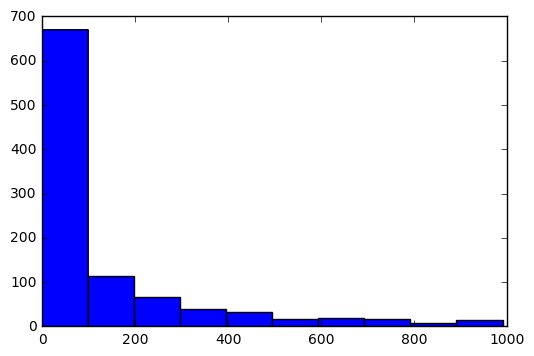

In [31]:
plt.hist(test)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000D3774B8630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000D37AE181D0>]], dtype=object)

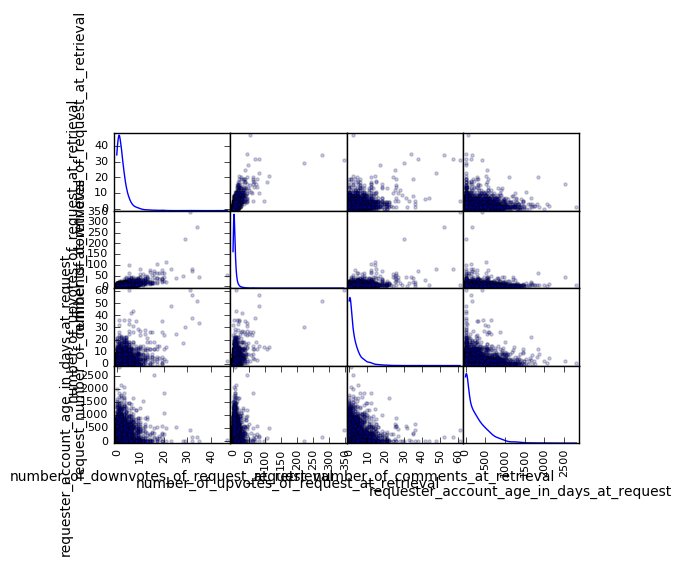

In [41]:
#from pandas.plotting import scatter_matrix

df = pd.io.json.json_normalize(trainjson)
df = df[['number_of_downvotes_of_request_at_retrieval', 'number_of_upvotes_of_request_at_retrieval', 
         'request_number_of_comments_at_retrieval', 'requester_account_age_in_days_at_request']]
pd.scatter_matrix(df, alpha=0.2, diagonal='kde')